# Regression Week 2: Multiple Linear Regression Quiz 2

## Estimating Multiple Regression Coefficients (Gradient Descent)

In this notebook we will cover estimating multiple regression weights via gradient descent. You will:

- Add a constant column of 1's to a SFrame (or otherwise) to account for the intercept
- Convert an SFrame into a numpy array
- Write a predict_output() function using numpy
- Write a numpy function to compute the derivative of the regression weights with respect to a single feature
- Write gradient descent function to compute the regression weights given an initial weight vector, step size and tolerance.
- Use the gradient descent function to estimate regression weights for multiple features

#### Import modules

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import zipfile
import os
from math import log
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

#### Unzip and load datasets

In [2]:
with zipfile.ZipFile('kc_house_data.csv.zip', "r") as z:
    z.extractall(os.getcwd())
with zipfile.ZipFile('kc_house_test_data.csv.zip', "r") as z:
    z.extractall(os.getcwd())
with zipfile.ZipFile('kc_house_train_data.csv.zip', "r") as z:
    z.extractall(os.getcwd())
    
# Dictionary with the correct dtypes for the DataFrame columns
dtype_dict = {'bathrooms':float, 'waterfront':int, 'sqft_above':int, 
              'sqft_living15':float, 'grade':int, 'yr_renovated':int, 
              'price':float, 'bedrooms':float, 'zipcode':str, 
              'long':float, 'sqft_lot15':float, 'sqft_living':float, 
              'floors':str, 'condition':int, 'lat':float, 'date':str, 
              'sqft_basement':int, 'yr_built':int, 'id':str, 'sqft_lot':int, 'view':int}
    
sales = pd.read_csv('kc_house_data.csv', dtype = dtype_dict)
train_data = pd.read_csv('kc_house_train_data.csv', dtype = dtype_dict)
test_data = pd.read_csv('kc_house_test_data.csv', dtype = dtype_dict)

#### Get numpy data

Write a function that takes a data set, a list of features (e.g. [‘sqft_living’, ‘bedrooms’]), to be used as inputs, and a name of the output (e.g. ‘price’). This function should return a features_matrix (2D array) consisting of first a column of ones followed by columns containing the values of the input features in the data set in the same order as the input list. It should also return an output_array which is an array of the values of the output in the data set 

In [3]:
def get_numpy_data(data_sframe, features, output):
    data_sframe['constant'] = 1 # add a constant column to an SFrame
    # prepend variable 'constant' to the features list
    features = ['constant'] + features
    # select the columns of data_SFrame given by the ‘features’ list into the SFrame ‘features_sframe’
    features_sframe = data_sframe[features]
    # this will convert the features_sframe into a numpy matrix with GraphLab Create >= 1.7!!
    features_matrix = features_sframe.as_matrix()
    # assign the column of data_sframe associated with the target to the variable ‘output_sarray’
    output_sarray = data_sframe[output]
    # this will convert the SArray into a numpy array:
    output_array = output_sarray.as_matrix() # GraphLab Create>= 1.7!!
    return(features_matrix, output_array)

In [4]:
(example_features, example_output) = get_numpy_data(sales, ['sqft_living'], 'price')
print(example_features[0,:])
print(example_output)

[  1.00000000e+00   1.18000000e+03]
[ 221900.  538000.  180000. ...,  402101.  400000.  325000.]


#### Predict outcome from regression model

If the features matrix (including a column of 1s for the constant) is stored as a 2D array (or matrix) and the regression weights are stored as a 1D array then the predicted output is just the dot product between the features matrix and the weights (with the weights on the right). Write a function ‘predict_output’ which accepts a 2D array ‘feature_matrix’ and a 1D array ‘weights’ and returns a 1D array ‘predictions’

In [5]:
def predict_output(feature_matrix, weights):
    predictions = np.dot(feature_matrix,weights)
    return(predictions)

In [6]:
predict_output(example_features[0,:],np.ones(2)) # testing previous function

1181.0

#### Derivatives

Recall that the cost function is the sum over the data points of the squared difference between an observed output and a predicted output. Since the derivative of a sum is the sum of the derivatives we can compute the derivative for a single data point and then sum over data points:

(w[0]*[CONSTANT] + w[1]*[feature_1] + ... + w[i] *[feature_i] + ... + w[k]*[feature_k] - output)^2

Derivative is:

2*(w[0]*[CONSTANT] + w[1]*[feature_1] + ... + w[i] *[feature_i] + ... + w[k]*[feature_k] - output)* [feature_i]

The term inside the paranethesis is just the error (difference between prediction and output). So we can re-write this as:

2*error*[feature_i]

If we have the values of a single input feature in an array ‘feature’ and the prediction ‘errors’ (predictions - output) then the derivative of the regression cost function with respect to the weight of ‘feature’ is just twice the dot product between ‘feature’ and ‘errors’.

In [7]:
def feature_derivative(errors, feature):
    derivative = 2*np.dot(errors, feature)
    return(derivative)

#### Gradient descent optimization

Now we will use our predict_output and feature_derivative to write a gradient descent function. Although we can compute the derivative for all the features simultaneously (the gradient) we will explicitly loop over the features individually for simplicity. Write a gradient descent function that does the following:

1. Accepts a numpy feature_matrix 2D array, a 1D output array, an array of initial weights, a step size and a convergence tolerance.
2. While not converged updates each feature weight by subtracting the step size times the derivative for that feature given the current weights
3. At each step computes the magnitude/length of the gradient (square root of the sum of squared components)
4. When the magnitude of the gradient is smaller than the input tolerance returns the final weight vector.

In [8]:
def regression_gradient_descent(feature_matrix, output, initial_weights, step_size, tolerance):
    loop_count = 0
    converged = False
    weights = np.array(initial_weights)
    while not converged:
        # compute the predictions based on feature_matrix and weights:
        predictions = predict_output(feature_matrix, weights)
        # compute the errors as predictions - output:
        errors = predictions - output
        gradient_sum_squares = 0 # initialize the gradient
        # while not converged, update each weight individually:
        for i in range(len(weights)):
            # Recall that feature_matrix[:, i] is the feature column associated with weights[i]
            # compute the derivative for weight[i]:
            derivative = feature_derivative(errors, feature_matrix[:,i])
            # add the squared derivative to the gradient magnitude
            gradient_sum_squares += (derivative)**2
            # update the weight based on step size and derivative:
            weights[i] -= step_size*derivative
        gradient_magnitude = np.sqrt(gradient_sum_squares)
        loop_count += 1
        if gradient_magnitude < tolerance:
            converged = True
    print("Number of total iteration: %d" % (loop_count))
    return(weights)

Split the sales data into training and test data. Use same seed as previous notebooks

## Model 1. Gradient descent as Simple Linear Regression

Now we will run the regression_gradient_descent function on some actual data. In particular we will use the gradient descent to estimate the model from Week 1 using just an intercept and slope. Use the following parameters:

+ features: ‘sqft_living’
+ output: ‘price’
+ initial weights: -47000, 1 (intercept, sqft_living respectively)
+ step_size = 7e-12
+ tolerance = 2.5e7

In [9]:
simple_features = ['sqft_living']
my_output= 'price'
(simple_feature_matrix, output) = get_numpy_data(train_data, simple_features, my_output)
initial_weights = np.array([-47000., 1.])
step_size = 7e-12
tolerance = 2.5e7

In [10]:
simple_weights = regression_gradient_descent(simple_feature_matrix, output, initial_weights, step_size, tolerance)
iter_number = 0
for simple_weight in np.nditer(simple_weights):
    print("Weight #%d: %f" % (iter_number, simple_weight))
    iter_number += 1

Number of total iteration: 12
Weight #0: -46999.887166
Weight #1: 281.912119


What is the value of the weight for sqft_living -- the second element of ‘simple_weights’ (rounded to 1 decimal place)?

In [11]:
round(float(simple_weights[1]),1)

281.9

Now build a corresponding ‘test_simple_feature_matrix’ and ‘test_output’ using test_data. Using ‘test_simple_feature_matrix’ and ‘simple_weights’ compute the predicted house prices on all the test data.

In [12]:
test_simple_feature_matrix, test_output = get_numpy_data(test_data, simple_features, my_output)

What is the predicted price for the 1st house in the Test data set for model 1 (round to nearest dollar)?

In [13]:
test_simple_predictions = predict_output(test_simple_feature_matrix, simple_weights)
round(test_simple_predictions[0],0)

356134.0

In image bellow: in the blue scatter plot we see the train data and in red, the tested data with the predicted feature (price)

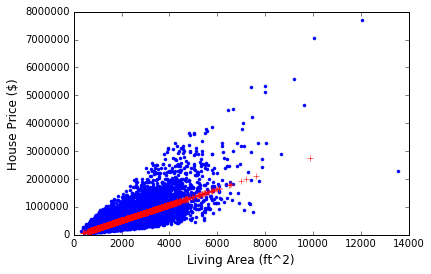

In [14]:
plt.plot(train_data[simple_features], train_data[my_output], ".b")
plt.plot(test_data[simple_features], test_simple_predictions, "+r")
plt.xlabel('Living Area (ft^2)', fontsize=12)
plt.ylabel('House Price ($)', fontsize=12)
plt.show()

Now compute RSS on all test data for this model. Record the value and store it for later

In [15]:
RSS_test_model_1 = sum( (test_simple_predictions-test_data['price'].values)**2.0 )
RSS_test_model_1

275400044902128.78

## Model 2. Gradient descent as Multiple Linear Regression (2 features)

Now we will use the gradient descent to fit a model with more than 1 predictor variable (and an intercept). Use the following parameters:

+ model features = ‘sqft_living’, ‘sqft_living_15’
+ output = ‘price’
+ initial weights = [-100000, 1, 1] (intercept, sqft_living, and sqft_living_15 respectively)
+ step size = 4e-12
+ tolerance = 1e9

In [16]:
model2_features = ['sqft_living', 'sqft_living15']
my_output = 'price'
(multiple_feature_matrix, output) = get_numpy_data(train_data, model2_features, my_output)
initial_weights = np.array([-100000., 1., 1.])
step_size = 4e-12
tolerance = 1e9

First I'm going to see how the 2 variables ‘sqft_living’ and ‘sqft_living_15’ are independently relationated with price (Note: sqft_living_15 is the average square feet of the nearest 15 neighbouring houses):

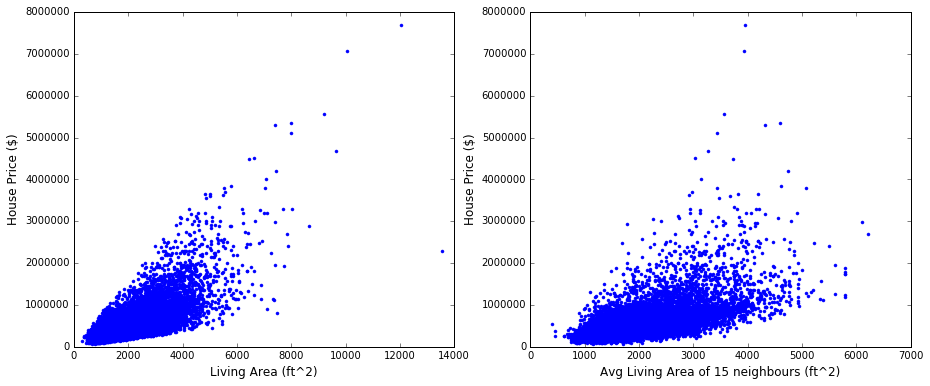

In [17]:
plt.figure(figsize=(15,6))

plt.subplot(1, 2, 1)
plt.plot(train_data[model2_features[0]], train_data[my_output], ".b")
plt.xlabel('Living Area (ft^2)', fontsize=12)
plt.ylabel('House Price ($)', fontsize=12)

plt.subplot(1, 2, 2)
plt.plot(train_data[model2_features[1]], train_data[my_output], ".b")
plt.xlabel('Avg Living Area of 15 neighbours (ft^2)', fontsize=12)
plt.ylabel('House Price ($)', fontsize=12)
plt.show()

Run gradient descent on a model with ‘sqft_living’ and ‘sqft_living_15’ as well as an intercept with the above parameters. Save the resulting regression weights. 

In [18]:
multiple_weights = regression_gradient_descent(multiple_feature_matrix, output, initial_weights, step_size, tolerance)
iter_number = 0
for multiple_weight in np.nditer(multiple_weights):
    print("Weight #%d: %f" % (iter_number, multiple_weight))
    iter_number += 1

Number of total iteration: 274
Weight #0: -99999.968849
Weight #1: 245.072603
Weight #2: 65.279527


Use the regression weights from this second model (using sqft_living and sqft_living_15) and predict the outcome of all the house prices on the TEST data.

In [19]:
test_multiple_feature_matrix, test_output = get_numpy_data(test_data, model2_features, my_output)
test_multiple_predictions = predict_output(test_multiple_feature_matrix, multiple_weights)


What is the predicted price for the 1st house in the TEST data set for model 2 (round to nearest dollar)?

In [20]:
round(test_multiple_predictions[0],0)

366651.0

What is the actual price for the 1st house in the Test data set?

In [21]:
round(test_data['price'][0],0)

310000.0

Which estimate was closer to the true price for the 1st house on the TEST data set, model 1 or model 2?

In [22]:
print("Deviation of model 1 in $: %f" % round(test_simple_predictions[0] - test_data['price'][0],0))
print("Deviation of model 2 in $: %f" % round(test_multiple_predictions[0] - test_data['price'][0],0))

Deviation of model 1 in $: 46134.000000
Deviation of model 2 in $: 56651.000000


Now compute RSS on all test data for the second model. Record the value and store it for later.

In [23]:
RSS_test_model_2 = sum( (test_multiple_predictions-test_data['price'].values)**2.0 )
RSS_test_model_2

270263443629803.31

Which model (1 or 2) has lowest RSS on all of the TEST data?

In [25]:
print("Is model 1 better than model 2? %s" % (RSS_test_model_2 > RSS_test_model_2))
print("Model 1 RSS: %f vs Model 2 RSS: %f" % (RSS_test_model_1, RSS_test_model_2))

Is model 1 better than model 2? False
Model 1 RSS: 275400044902128.781250 vs Model 2 RSS: 270263443629803.312500
